The goal here is to read in the HEALPix pixels for the modifed WFD footprint and create a skymap with RA, Dec labels (not doable with `healpy` so need to use the `mollweide` projection from `matplotlib`. We also overplot the all-band WFD footprint from `kraken2016` for comparison.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import os
import healpy as hp
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
import lsst.sims.maf.metricBundles as metricBundles
from matplotlib.lines import Line2D

In [2]:
fontsize = 16
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['xtick.labelsize'] = fontsize-2
mpl.rcParams['ytick.labelsize'] = fontsize-2
mpl.rcParams['legend.fontsize'] = fontsize-2
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.grid'] = True
mpl.rcParams['figure.titlesize'] = fontsize

**Set up some things**

In [3]:
# data characteristics
nside = 256

# path for proposed WFD footprint
data_dir = '/global/homes/a/awan/desc/wfd_footprint/'
filepath = '%sWFDfootprint_nside%s_HEALPixels.csv'%(data_dir, nside)

# path + tags to read in coadd data for baseline2018a; saved data has masks for each band
file_yearTag = 'fullSurveyPeriod'
dbname = 'kraken_2026'
coadd_data_dir = '/global/cscratch1/sd/awan/lsst_output/coadd_output_allwps_perNight/'

**Read in the coadd data for the kraken_2026**

In [4]:
data_bundle = {}   
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    # set up the folders
    folder = 'coaddM5Analysis_nside%s_withDustExtinction_'%(nside)
    folder += '0pixelRadiusForMasking_%sBand_%s_%s_directory/'%(band, dbname, file_yearTag)
    path = '%s/%s/unmaskedCoaddData/'%(coadd_data_dir, folder)
    # get the filenames
    filenames = [f for f in os.listdir(path) if f.endswith('.npz')]
    print('Reading %s from\n%s/unmaskedCoaddData.\n'%(filenames, folder))

    if len(filenames)>1:
        err = 'Have more than one npz file for %s band'%band
        err += ' for %s data: %s'%(yr_cut, filenames)
        raise ValueError(err)
    else:
        dither = filenames[0].split('%s_'%band)[-1]
        dither = dither.split('.npz')[0]
        mB = metricBundles.createEmptyMetricBundle()
        mB.read('%s/%s'%(path, filenames[0]))
        data_bundle['%s'%(band)]= mB

Reading ['coaddM5Data_unmasked_u_RandomDitherPerNight.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_uBand_kraken_2026_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_g_RandomDitherPerNight.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_gBand_kraken_2026_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_r_RandomDitherPerNight.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_rBand_kraken_2026_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_i_RandomDitherPerNight.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_iBand_kraken_2026_fullSurveyPeriod_directory//

**Find the all-band footprint for kraken_2026**

In [5]:
all_band_pixels = None

for band in data_bundle:
    index = np.where((data_bundle[band].metricValues.mask == False) & \
                     (data_bundle[band].metricValues.data > 0))[0]
    # save the indices
    if all_band_pixels is None:
        # initate the list
        all_band_pixels = index
    else:
        # keep only the overlapping pixels
        all_band_pixels = list(set(all_band_pixels).intersection(index))

**Plot the skymap for the all-band kraken_2026 WFD**

In [6]:
def get_area(pix_arr, nside):
    return len(pix_arr)*hp.nside2pixarea(nside=nside, degrees=True)

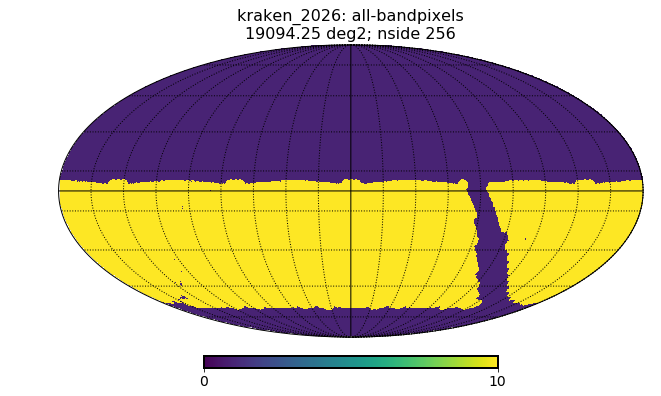

In [7]:
# set up the skymaps
nPix = hp.nside2npix(nside)
vals = np.zeros(nPix)+1.  # initiate all data to 1
vals[all_band_pixels] = 5000   # add fake data to the pixels in our list

title = '%s: all-bandpixels\n%.2f deg2; nside %s'%(dbname,
                                                   get_area(all_band_pixels, nside),
                                                   nside)
# plot the skymap
plt.clf()
hp.mollview(vals, flip='astro', rot=(0,0,0), min=0, max=10, title=title)
hp.graticule(dpar=20, dmer=20, verbose=False)
plt.show()

**Now read in the pixel list for proposed WFD and plot the skymap**

## Reading in /global/homes/a/awan/desc/wfd_footprint/WFDfootprint_nside256_HEALPixels.csv


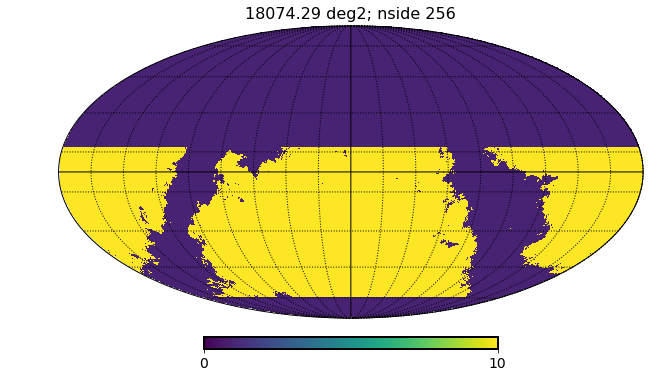

In [8]:
print('## Reading in %s'%filepath)
data = pd.read_csv(filepath)
# extract the pixel numbers
new_wfd_pixels = [int(f) for f in data['pixNum']]

# set up the skymaps
nPix = hp.nside2npix(nside)
vals = np.zeros(nPix)+1.  # initiate all data to 1
vals[new_wfd_pixels] = 5000   # add fake data to the pixels in our list

# plot the skymap
plt.clf()
hp.mollview(vals, flip='astro', rot=(0,0,0), min=0, max=10,
            title='%.2f deg2; nside %s'%(get_area(new_wfd_pixels, nside), nside)
           )
hp.graticule(dpar=20, dmer=20, verbose=False)
plt.show()

**Okay, now lets create the mollweide skymaps using matplotlib** since we want to label ra, dec lines.

We use hp.pix2ang to get latitude, longitude corresponding to each pixel number. Then, pixel dec = np.pi/2 - latitude and ra = longitude.

kraken_2026: -65.14 <= dec <= 5.83
proposd wfd: -69.98 <= dec <= 12.48


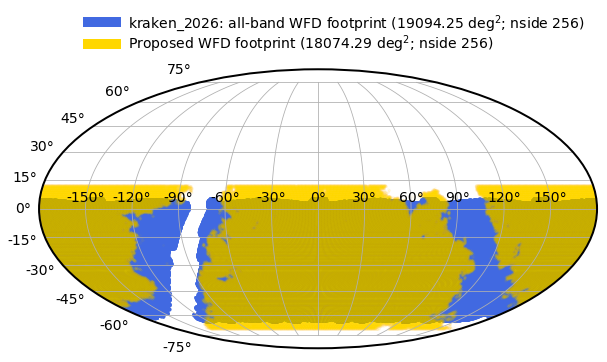

In [9]:
plt.figure()
plt.subplot(111, projection="mollweide")

# set up some plotting params
size = 4.0
colors = ['royalblue', 'gold'] #  lightcoral, lightskyblue, darkviolet, rebeccapurple, maroon
alphas = [0.5, 0.03]
name = [dbname, 'proposd wfd']
titles = ['%s: all-band WFD footprint'%dbname, 'Proposed WFD footprint']

ras, decs = {}, {}
# loop over baseline pixels and those for the proposed WFD
for i, pixs in enumerate([all_band_pixels, new_wfd_pixels]):
    # convert healpix pixels to ra, dec values
    lat, ra = hp.pix2ang(ipix=pixs, nside=nside)
    ra = np.remainder(ra+np.pi*2, np.pi*2)
    dec = np.pi/2.0 - lat
    c = SkyCoord(ra=ra * u.radian, dec=dec * u.radian, frame='icrs')
    ra_rad = c.ra.wrap_at(180. * u.deg).radian
    dec_rad = c.dec.radian

    print('%s: %.2f <= dec <= %.2f'%(name[i], min(np.degrees(dec)), max(np.degrees(dec))))
    # plot the ra, dec
    plt.scatter(ra_rad, dec_rad, s=size, color=colors[i], alpha=alphas[i])
    
    ras[name[i]], decs[name[i]] = ra_rad, dec_rad
# add legend
ax = plt.gca()
custom_lines = [Line2D([0], [0], color=colors[0], lw=10),
                Line2D([0], [0], color=colors[1], lw=10)]
ax.legend(custom_lines,
          ['%s (%.2f deg$^2$; nside %s)'%(titles[0], get_area(all_band_pixels, nside), nside),
           '%s (%.2f deg$^2$; nside %s)'%(titles[1], get_area(new_wfd_pixels, nside), nside)],
          bbox_to_anchor=(1.,1.25), frameon=False, labelspacing=0.001)
plt.show()

Okay the RA is increasing to the right -- dont want that. Lets shift the RA values and relabel the ra labels.

kraken_2026: -69.98 <= dec <= 12.48
proposd wfd: -69.98 <= dec <= 12.48
Old labels: [-150. -120.  -90.  -60.  -30.    0.   30.   60.   90.  120.  150.]
News labels: [ 150.  120.   90.   60.   30.    0.  -30.  -60.  -90. -120. -150.]

## Saved WFDfootprint_proposed_vs_kraken_2026_nside256_matplotlib.png


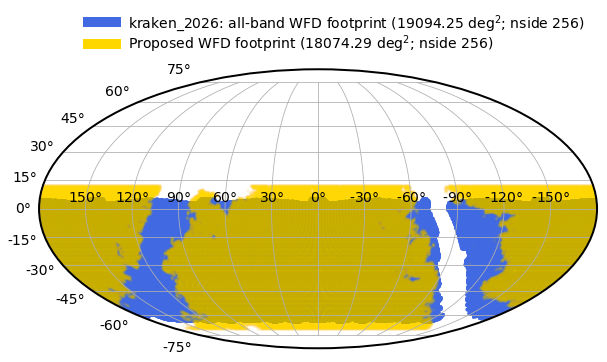

In [10]:
plt.figure()
plt.subplot(111, projection="mollweide")

for i, pixs in enumerate([all_band_pixels, new_wfd_pixels]):
    # flip the ra
    ra_rad, dec_rad = -ras[name[i]], decs[name[i]]
    
    # plot the ra, dec
    plt.scatter(ra_rad, dec_rad, s=size, color=colors[i], alpha=alphas[i])
    print('%s: %.2f <= dec <= %.2f'%(name[i], min(np.degrees(dec)), max(np.degrees(dec))))

# add legend
ax = plt.gca()
custom_lines = [Line2D([0], [0], color=colors[0], lw=10),
                Line2D([0], [0], color=colors[1], lw=10)]
ax.legend(custom_lines,
          ['%s (%.2f deg$^2$; nside %s)'%(titles[0], get_area(all_band_pixels, nside), nside),
           '%s (%.2f deg$^2$; nside %s)'%(titles[1], get_area(new_wfd_pixels, nside), nside)],
          bbox_to_anchor=(1.,1.25), frameon=False, labelspacing=0.001)

# ---------------------------------------------
# relabel stuff
locs, label = plt.xticks()
labels = np.rad2deg(locs)
print('Old labels: %s'%labels)
labels[labels!=0] = -labels[labels!=0]
print('News labels: %s'%labels)
labels = [r'%.f$\degree$'%(f) for f in labels]
plt.gca().set_xticklabels(labels)
# ---------------------------------------------
# save plot
filename = 'WFDfootprint_proposed_vs_%s_nside%s_matplotlib.png'%(dbname, nside)
#plt.savefig(filename='%s%s'%(data_dir, filename), format='png', bbox_inches='tight')
print('\n## Saved %s'%filename)
plt.show()

**Lets also plot the skymaps individually**

kraken_2026: -69.98 <= dec <= 12.48
Old labels: [-150. -120.  -90.  -60.  -30.    0.   30.   60.   90.  120.  150.]
News labels: [ 150.  120.   90.   60.   30.    0.  -30.  -60.  -90. -120. -150.]

## Saved WFDfootprint_kraken_2026_nside256_matplotlib.png


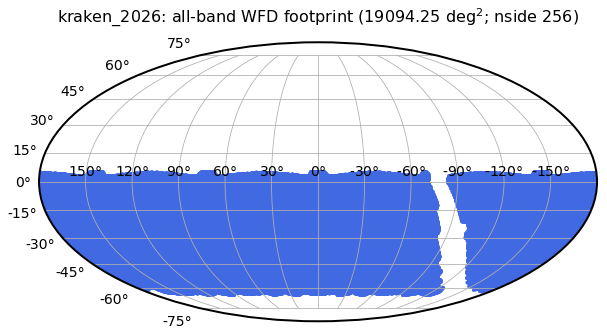

proposd wfd: -69.98 <= dec <= 12.48
Old labels: [-150. -120.  -90.  -60.  -30.    0.   30.   60.   90.  120.  150.]
News labels: [ 150.  120.   90.   60.   30.    0.  -30.  -60.  -90. -120. -150.]

## Saved WFDfootprint_proposed_nside256_matplotlib.png


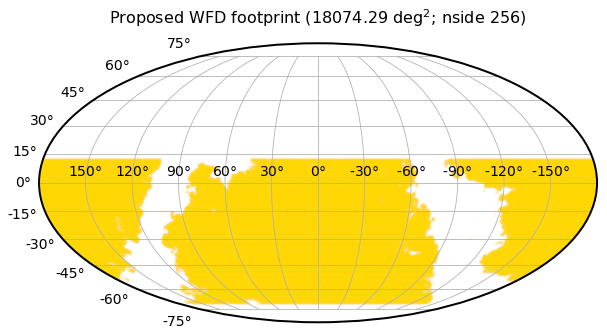

In [11]:
filetag = [dbname, 'proposed']
for i, pixs in enumerate([all_band_pixels, new_wfd_pixels]):
    plt.figure()
    plt.subplot(111, projection="mollweide")

    # flip the ra
    ra_rad, dec_rad = -ras[name[i]], decs[name[i]]
    
    # plot the ra, dec
    plt.scatter(ra_rad, dec_rad, s=size, color=colors[i], alpha=alphas[i])
    print('%s: %.2f <= dec <= %.2f'%(name[i], min(np.degrees(dec)), max(np.degrees(dec))))

    plt.title('%s (%.2f deg$^2$; nside %s)'%(titles[i], get_area(pixs, nside), nside), y=1.05)
    
    # ---------------------------------------------
    # relabel stuff
    locs, label = plt.xticks()
    labels = np.rad2deg(locs)
    print('Old labels: %s'%labels)
    labels[labels!=0] = -labels[labels!=0]
    print('News labels: %s'%labels)
    labels = [r'%.f$\degree$'%(f) for f in labels]
    plt.gca().set_xticklabels(labels)
    # ---------------------------------------------
    # save plot
    filename = 'WFDfootprint_%s_nside%s_matplotlib.png'%(filetag[i], nside)
    plt.savefig(filename='%s%s'%(data_dir, filename), format='png', bbox_inches='tight')
    print('\n## Saved %s'%filename)
    plt.show()